### Example of Applying Class Weighting

Model G8.2, ISIC 2018 dataset, Barata et al. (2021) - ResNet-50 model variant, categorical cross entropy loss function, batch size = 16, lr = 1e-4, augmentation = No, SMOTE-Tomek = No, class weighting = yes, Top 32 layers trainable

In [ ]:
#import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.resnet import preprocess_input
import tensorflow as tf
import random

#class weighting in model training to handle imbalanced classes
from sklearn.utils.class_weight import compute_class_weight

#save performance metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
import json

In [ ]:
#setup for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

#general Configuration
LOSS ='categorical_crossentropy'
CLASS_NAMES=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

#......................................................................................
checkpoint_path = "/content/drive/MyDrive/Deep Learning/Results/best_model_v8.2.h5"

In [ ]:
#Flags (class with general configurations)
class Flags:
    dim_hidden = 512
    ratio = 8
    learning_rate = 1e-4
    num_classes = 7
    batch_size = 16
    max_epochs = 40 #later dataset testing
    #patience = 5
    patience=10,  #patience increased to give more time for training
    input_shape = (224, 224, 3)

In [ ]:
#Attention module
def channel_attention(inputs, ratio=8):
    channel = inputs.shape[-1]
    avg_pool = layers.GlobalAveragePooling2D()(inputs)
    max_pool = layers.GlobalMaxPooling2D()(inputs)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)

    shared_dense = tf.keras.Sequential([
        layers.Conv2D(channel // ratio, 1, activation='relu', padding='same'),
        layers.Conv2D(channel, 1, padding='same')
    ])

    avg_out = shared_dense(avg_pool)
    max_out = shared_dense(max_pool)
    scale = layers.Activation('sigmoid')(layers.Add()([avg_out, max_out]))
    return layers.Multiply()([inputs, scale])

#Hierachical Attention based module, #build the model, fine-tuning and allowing training
def build_resnet50_attention_lstm_model(input_shape=(224, 224, 3), num_classes=Flags.num_classes, learning_rate = Flags.learning_rate):
    input_layer = layers.Input(shape=input_shape)
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_layer)

    for layer in base_model.layers[:-32]:
        layer.trainable = False
    for layer in base_model.layers[-32:]:
        layer.trainable = True

    x = base_model.output
    x = channel_attention(x, ratio=Flags.ratio)
    x = layers.Reshape((-1, 2048))(x)

    avg_feat = layers.GlobalAveragePooling1D()(x)
    init_state = layers.Dense(Flags.dim_hidden * 2, activation='tanh')(avg_feat)
    h_state = layers.Lambda(lambda z: z[:, :Flags.dim_hidden])(init_state)
    c_state = layers.Lambda(lambda z: z[:, Flags.dim_hidden:])(init_state)

    lstm_out, _, _ = layers.LSTM(Flags.dim_hidden, return_sequences=True, return_state=True)(x, initial_state=[h_state, c_state])
    x_proj = layers.Dense(Flags.dim_hidden)(x)
    context = layers.Attention()([lstm_out, x_proj])
    context = layers.GlobalAveragePooling1D()(context)

    x = layers.Concatenate()([context, avg_feat])
    x = layers.Dense(Flags.dim_hidden, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(Flags.num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),loss=LOSS,metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

In [ ]:
#............ Utility Functions ............

#extracts downloaded data from zip file format
def extract_zip(filename, target_path="."):
    with ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(target_path)

#loads and preprocesses the label data (target)
def load_and_process_labels(csv_path):
    df = pd.read_csv(csv_path)
    df['new_image_id'] = df['image'] + ".jpg"

    #create label column from diagnosis columns
    diagnosis_cols = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

    #find the index (i.e., label) where the value is 1
    df['label'] = df[diagnosis_cols].idxmax(axis=1)

    #map string labels to integers
    label_mapping = {'MEL': 0, 'NV': 1, 'BCC': 2, 'AKIEC': 3, 'BKL': 4, 'DF': 5, 'VASC': 6}
    df['label'] = df['label'].map(label_mapping)

    return df

#determine the distribution of classes in the dataset
def show_class_distribution(y, title="Class Distribution"):
    unique, counts = np.unique(y, return_counts=True)

    class_labels = [
        'Melanoma (0)',         # MEL
        'Nevus (1)',            # NV
        'Basal Cell Carcinoma (2)',  # BCC
        'Actinic Keratosis (3)',     # AKIEC
        'Benign Keratosis (4)',      # BKL
        'Dermatofibroma (5)',        # DF
        'Vascular Lesion (6)'        # VASC
    ]

    print(f"\n{title}:")
    for label, count in zip(unique, counts):
        class_name = class_labels[label] if label < len(class_labels) else f"Unknown Class ({label})"
        print(f"  Class {label} ({class_name}): {count} samples")

#downsamples majority classes in a DataFrame to match the target_count
def downsample_selected_classes(df, target_count=3352, labels_to_downsample=[1], label_col='label', random_state=42):
    downsampled_dfs = []

    for label in df[label_col].unique():
        class_subset = df[df[label_col] == label]

        if label in labels_to_downsample and len(class_subset) > target_count:
            class_subset = class_subset.sample(n=target_count, random_state=random_state)

        downsampled_dfs.append(class_subset)

    return pd.concat(downsampled_dfs).sample(frac=1, random_state=random_state).reset_index(drop=True)

#load the image dataset and preprocess e.g. correct color format, reszie, map labels
def load_images(df, img_dir):
    X, y = [], []
    for _, row in df.iterrows():
        img_path = os.path.join(img_dir, row['new_image_id'])
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is None:
                continue  # skip corrupted image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, Flags.input_shape[:2])
            X.append(img.astype('float32') / 255.0)
            y.append(row['label'])
    X = np.array(X)
    y = np.array(y)
    print(f"Loaded {len(X)} images from {img_dir}")
    return X, y

#show some data samples
def show_samples(X, y, n=6):
    plt.figure(figsize=(12, 5))
    for i in range(n):
        plt.subplot(2, n // 2, i + 1)
        plt.imshow(X[i])
        plt.title(f"Label: {y[i]}")
        plt.axis("off")
    plt.suptitle('Sample data')
    plt.show()

#training of the model
def train_model(model, X, y, X_val, y_val):
    y_encoded = to_categorical(y, num_classes=Flags.num_classes)
    y_val_encoded = to_categorical(y_val, num_classes=Flags.num_classes)

    early_stop = EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_auc',
        mode='max',
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=1e-6
    )

     #......................................
    checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )
    #......................................


    class PrintLearningRate(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        val_acc = logs.get('val_accuracy')
        val_loss = logs.get('val_loss')
        val_auc = logs.get('val_auc')
        print(f"\nEpoch {epoch + 1} Summary:")
        print(f"  Learning Rate : {lr:.6f}")
        print(f"  Val Accuracy  : {val_acc:.4f}")
        print(f"  Val Loss      : {val_loss:.4f}")
        if val_auc is not None:
            print(f"  Val AUC       : {val_auc:.4f}")

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

    history = model.fit(
        X, y_encoded,
        validation_data=(X_val, y_val_encoded),
        epochs=Flags.max_epochs,
        batch_size=Flags.batch_size,
        class_weight=class_weights_dict,
        callbacks=[early_stop, lr_scheduler, checkpoint, PrintLearningRate()],
        shuffle=True
    )
    return history


#evaluate the model based pn metrics e.g. accuracy, precision, recall, sensitivity, specificity
def evaluate_model(y_true, y_pred, y_proba, class_names):
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("\nSensitivity and Specificity per class:")
    for i, cls in enumerate(class_names):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        print(f"Class: {cls}")
        print(f"  Sensitivity: {TP / (TP + FN):.4f}")
        print(f"  Specificity: {TN / (TN + FP):.4f}")

    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
    auc_macro = roc_auc_score(y_true_bin, y_proba, average='macro', multi_class='ovr')
    auc_micro = roc_auc_score(y_true_bin, y_proba, average='micro', multi_class='ovr')
    auc_weighted = roc_auc_score(y_true_bin, y_proba, average='weighted', multi_class='ovr')

    print(f"\nAUC (macro): {auc_macro:.4f}")
    print(f"AUC (micro): {auc_micro:.4f}")
    print(f"AUC (weighted): {auc_weighted:.4f}")

#show training history plot
def plot_history(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Training History")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.legend()
    plt.grid(True)

    plt.savefig("/content/drive/MyDrive/Deep Learning/Results/training_history_v8.2.png")
    plt.show()

#plot ROC curve for each class and micro/macro average ROC.
def plot_multiclass_roc(y_true, y_proba, class_names):
    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
    n_classes = y_true_bin.shape[1]

    #compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    #plot all ROC curves
    plt.figure(figsize=(10, 8))

    #plot macro and micro averages
    plt.plot(fpr["micro"], tpr["micro"],
             label='Micro-average ROC (area = {0:0.2f})'.format(roc_auc["micro"]),
             linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='Macro-average ROC (area = {0:0.2f})'.format(roc_auc["macro"]),
             linestyle=':', linewidth=4)

    #plot ROC curve for each class
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC for class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.savefig("/content/drive/MyDrive/Deep Learning/Results/roc_curve_v8.2.png")
    plt.show()

In [ ]:
#mount drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

#paths -> Note replace these paths with the paths on appropriate drive e.g. Google drive
train_zip = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Training_Input.zip"
test_zip = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Test_Input.zip"
val_zip = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Validation_Input.zip"
train_csv = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Training_GroundTruth.csv"
test_csv = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Test_GroundTruth.csv"
val_csv = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Validation_GroundTruth.csv"
train_dir = "/content/ISIC2018_Task3_Training_Input"
test_dir = "/content/ISIC2018_Task3_Test_Input"
val_dir = "/content/ISIC2018_Task3_Validation_Input"


Mounted at /content/drive


In [ ]:
#Extract and Load
extract_zip(train_zip)
extract_zip(test_zip)
extract_zip(val_zip)
train_df = load_and_process_labels(train_csv)
test_df  = load_and_process_labels(test_csv)
val_df  = load_and_process_labels(val_csv)

#Class distribution
show_class_distribution(train_df['label'].values, title="Training Data")
show_class_distribution(test_df['label'].values, title="Testing Data")
show_class_distribution(val_df['label'].values, title="Validation Data")

#Load Data
X_train, y_train = load_images(train_df, train_dir)
X_test, y_test = load_images(test_df, test_dir)
X_val, y_val = load_images(val_df, val_dir)

print(f"Final X_test shape: {X_test.shape}, dtype: {X_test.dtype}")
assert len(X_test.shape) == 4 and X_test.shape[1:] == (224, 224, 3), "X_test shape is invalid"

print("X_train shape:", X_train.shape)  # should be (N, 224, 224, 3)
assert len(X_train.shape) == 4 and X_train.shape[1:] == (224, 224, 3), "X_train shape is invalid"
print("y_train shape:", y_train.shape)  # should be (N,)

print("X_val shape:", X_val.shape)  # should be (N, 224, 224, 3)
assert len(X_val.shape) == 4 and X_val.shape[1:] == (224, 224, 3), "X_val shape is invalid"
print("y_val shape:", y_val.shape)  # should be (N,)



Training Data:
  Class 0 (Melanoma (0)): 1113 samples
  Class 1 (Nevus (1)): 6705 samples
  Class 2 (Basal Cell Carcinoma (2)): 514 samples
  Class 3 (Actinic Keratosis (3)): 327 samples
  Class 4 (Benign Keratosis (4)): 1099 samples
  Class 5 (Dermatofibroma (5)): 115 samples
  Class 6 (Vascular Lesion (6)): 142 samples

Testing Data:
  Class 0 (Melanoma (0)): 171 samples
  Class 1 (Nevus (1)): 909 samples
  Class 2 (Basal Cell Carcinoma (2)): 93 samples
  Class 3 (Actinic Keratosis (3)): 43 samples
  Class 4 (Benign Keratosis (4)): 217 samples
  Class 5 (Dermatofibroma (5)): 44 samples
  Class 6 (Vascular Lesion (6)): 35 samples

Validation Data:
  Class 0 (Melanoma (0)): 21 samples
  Class 1 (Nevus (1)): 123 samples
  Class 2 (Basal Cell Carcinoma (2)): 15 samples
  Class 3 (Actinic Keratosis (3)): 8 samples
  Class 4 (Benign Keratosis (4)): 22 samples
  Class 5 (Dermatofibroma (5)): 1 samples
  Class 6 (Vascular Lesion (6)): 3 samples
Loaded 10015 images from /content/ISIC2018_Tas

In [ ]:
#..................... Main Execution .....................

def main():

    #build and train model
    model = build_resnet50_attention_lstm_model((224, 224, 3), Flags.num_classes, Flags.learning_rate)

    #check which layers are trainable
    print("\nTrainable layers:")
    for layer in model.layers:
        if layer.trainable:
            print(f"  {layer.name}")

    model.summary()

    history = train_model(model, X_train, y_train, X_val, y_val)

    #......................................
    model.load_weights(checkpoint_path)  #Load best model
    if os.path.exists(checkpoint_path):
      model.load_weights(checkpoint_path)
      print("Best checkpoint model loaded.")
    else:
      print("Best checkpoint model not found. Using last trained weights.")

    model.save("/content/drive/MyDrive/Deep Learning/Results/skin_cancer_resnet50_model_best_v8.2.h5")
    #......................................

    #predict and evaluate
    y_proba = model.predict(X_test)
    y_pred = np.argmax(y_proba, axis=1)
    evaluate_model(y_test, y_pred, y_proba, class_names=CLASS_NAMES)
    print(f"Balanced Accuracy (BACC): {balanced_accuracy_score(y_test, y_pred):.4f}")

    plot_multiclass_roc(y_test, y_proba, class_names=CLASS_NAMES)

    #plot training history
    plot_history(history)

    #save prediction results
    results_df = pd.DataFrame({
        'Image': test_df['new_image_id'],
        'True Label': y_test,
        'Predicted Label': y_pred,
        'Correct': (y_test == y_pred).astype(int)
    })

    for i, class_name in enumerate(CLASS_NAMES):
        results_df[f'Prob_{class_name}'] = y_proba[:, i]

    results_df.to_csv("/content/drive/MyDrive/Deep Learning/Results/prediction_results_v8.2.csv", index=False)

    #save performance metrics
    y_true_bin = label_binarize(y_test, classes=np.arange(len(CLASS_NAMES)))

    #get best epoch index based on val_auc
    best_epoch = np.argmax(history.history['val_auc'])

    metrics_dict = {
        'Best Epoch': int(best_epoch + 1),
        'Train Accuracy': history.history['accuracy'][best_epoch],
        'Val Accuracy': history.history['val_accuracy'][best_epoch],
        'Train Loss': history.history['loss'][best_epoch],
        'Val Loss': history.history['val_loss'][best_epoch],
        'Val AUC': history.history['val_auc'][best_epoch],
    }

    #.......................................
    metrics_dict = {
        'Best Epoch': int(best_epoch + 1),
        'Train Accuracy': history.history['accuracy'][best_epoch],
        'Val Accuracy': history.history['val_accuracy'][best_epoch],
        'Train Loss': history.history['loss'][best_epoch],
        'Val Loss': history.history['val_loss'][best_epoch],
        'Val AUC': history.history['val_auc'][best_epoch],
        'Test Accuracy': np.mean(y_pred == y_test),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
        'AUC Macro': roc_auc_score(y_true_bin, y_proba, average='macro', multi_class='ovr'),
        'AUC Micro': roc_auc_score(y_true_bin, y_proba, average='micro', multi_class='ovr'),
        'AUC Weighted': roc_auc_score(y_true_bin, y_proba, average='weighted', multi_class='ovr'),
        'F1 Macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'F1 Weighted': f1_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall Macro': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'Sensitivity Macro': recall_score(y_test, y_pred, average='macro', zero_division=0)
    }

    #..........................................

    cm = confusion_matrix(y_test, y_pred)
    for i, class_name in enumerate(CLASS_NAMES):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0

        #................................................
        metrics_dict[f'Specificity_{class_name}'] = specificity
        metrics_dict[f'Sensitivity_{class_name}'] = recall_score(y_test == i, y_pred == i, zero_division=0)
        metrics_dict[f'F1_{class_name}'] = f1_score(y_test == i, y_pred == i, zero_division=0)
        metrics_dict[f'Recall_{class_name}'] = recall_score(y_test, y_pred, labels=[i], average=None, zero_division=0)[0]
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        metrics_dict[f'ROC_{class_name}'] = auc(fpr, tpr)
        #................................................

    metrics_df = pd.DataFrame([metrics_dict])
    metrics_df.to_csv("/content/drive/MyDrive/Deep Learning/Results/model_metrics_detailed_v8.2.csv", index=False)



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Trainable layers:
  conv5_block1_1_conv
  conv5_block1_1_bn
  conv5_block1_1_relu
  conv5_block1_2_conv
  conv5_block1_2_bn
  conv5_block1_2_relu
  conv5_block1_0_conv
  conv5_block1_3_conv
  conv5_block1_0_bn
  conv5_block1_3_bn
  conv5_block1_add
  conv5_block1_out
  conv5_block2_1_conv
  conv5_block2_1_bn
  conv5_block2_1_relu
  conv5_block2_2_conv
  conv5_block2_2_bn
  conv5_block2_2_relu
  conv5_block2_3_conv
  conv5_block2_3_bn
  conv5_block2_add
  conv5_block2_out
  conv5_block3_1_conv
  conv5_block3_1_bn
  conv5_block3_1_relu
  conv5_block3_2_conv
  conv5_block3_2_bn
  conv5_block3_2_relu
  conv5_block3_3_conv
  conv5_block3_3_bn
  conv5_block3_add
  conv5_block3_out
  global_average_pooling2d
  global_max_pooling2d
  reshape
  reshape_1
  sequential
  add
  activation
  multiply
  reshape_2
  global_average_pooling1d
  dense
  lambda
  lambda_1
  lstm
  dense_1
  attention
  global_average_pooling1d_1
  concatenate
  dense_2


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 34,345,607 (131.02 MB)

 Trainable params: 25,733,895 (98.17 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

Epoch 1/40
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1491 - auc: 0.5608 - loss: 2.0311
Epoch 1: val_auc improved from -inf to 0.44962, saving model to /content/drive/MyDrive/Deep Learning/Results/best_model_v9.1-4.h5



Epoch 1 Summary:
  Learning Rate : 0.000100
  Val Accuracy  : 0.0052
  Val Loss      : 2.0004
  Val AUC       : 0.4496
626/626 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.1491 - auc: 0.5607 - loss: 2.0311 - val_accuracy: 0.0052 - val_auc: 0.4496 - val_loss: 2.0004 - learning_rate: 1.0000e-04
Epoch 2/40
625/626 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1412 - auc: 0.5483 - loss: 1.9310
Epoch 2: val_auc did not improve from 0.44962

Epoch 2 Summary:
  Learning Rate : 0.000100
  Val Accuracy  : 0.0415
  Val Loss      : 2.0037
  Val AUC       : 0.3130
626/626 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.1412 - auc: 0.5484 - loss: 1.9312 - val_accuracy: 0.0415 - val_auc: 0.3130 - val_loss: 2.0037 - learning_rate: 1.0000e-04
Epoch 3/40
625/626 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1193 - auc: 0.5263 - loss: 1.9252
Epoch 3: val_auc improved from 0.44962 to 0.51727, saving model to /content/drive/MyDrive/Deep Learning/Results/best_model_v9.1-4.h5



Epoch 3 Summary:
  Learning Rate : 0.000100
  Val Accuracy  : 0.0052
  Val Loss      : 1.9428
  Val AUC       : 0.5173
626/626 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.1194 - auc: 0.5263 - loss: 1.9253 - val_accuracy: 0.0052 - val_auc: 0.5173 - val_loss: 1.9428 - learning_rate: 1.0000e-04
Epoch 4/40
625/626 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1749 - auc: 0.4873 - loss: 1.9154
Epoch 4: val_auc did not improve from 0.51727

Epoch 4 Summary:
  Learning Rate : 0.000100
  Val Accuracy  : 0.0415
  Val Loss      : 1.9894
  Val AUC       : 0.2671
626/626 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.1749 - auc: 0.4873 - loss: 1.9155 - val_accuracy: 0.0415 - val_auc: 0.2671 - val_loss: 1.9894 - learning_rate: 1.0000e-04
Epoch 5/40
625/626 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1057 - auc: 0.5185 - loss: 1.9267
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 5: val_auc did not improve from 0.51727

Epoch 5 Summary:
  Learning Ra


Epoch 10 Summary:
  Learning Rate : 0.000012
  Val Accuracy  : 0.6269
  Val Loss      : 1.7474
  Val AUC       : 0.7732
626/626 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.1015 - auc: 0.5004 - loss: 1.9012 - val_accuracy: 0.6269 - val_auc: 0.7732 - val_loss: 1.7474 - learning_rate: 1.2500e-05
Epoch 11/40
625/626 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4282 - auc: 0.7135 - loss: 1.8386
Epoch 11: val_auc improved from 0.77319 to 0.78304, saving model to /content/drive/MyDrive/Deep Learning/Results/best_model_v9.1-4.h5



Epoch 11 Summary:
  Learning Rate : 0.000012
  Val Accuracy  : 0.6321
  Val Loss      : 1.6180
  Val AUC       : 0.7830
626/626 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.4280 - auc: 0.7135 - loss: 1.8386 - val_accuracy: 0.6321 - val_auc: 0.7830 - val_loss: 1.6180 - learning_rate: 1.2500e-05
Epoch 12/40
625/626 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3559 - auc: 0.7289 - loss: 1.7939
Epoch 12: val_auc did not improve from 0.78304

Epoch 12 Summary:
  Learning Rate : 0.000012
  Val Accuracy  : 0.0155
  Val Loss      : 1.6650
  Val AUC       : 0.7085
626/626 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.3557 - auc: 0.7289 - loss: 1.7939 - val_accuracy: 0.0155 - val_auc: 0.7085 - val_loss: 1.6650 - learning_rate: 1.2500e-05
Epoch 13/40
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3090 - auc: 0.7372 - loss: 1.7486
Epoch 13: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 13: val_auc did not improve from 0.78304

Epoch 13 Summary:
  Lear

Best checkpoint model loaded.
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step
Classification Report:
               precision    recall  f1-score   support

         MEL       0.40      0.04      0.06       171
          NV       0.62      0.99      0.76       909
         BCC       0.00      0.00      0.00        93
       AKIEC       0.06      0.02      0.03        43
         BKL       0.00      0.00      0.00       217
          DF       0.04      0.02      0.03        44
        VASC       0.00      0.00      0.00        35

    accuracy                           0.60      1512
   macro avg       0.16      0.15      0.13      1512
weighted avg       0.42      0.60      0.47      1512



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


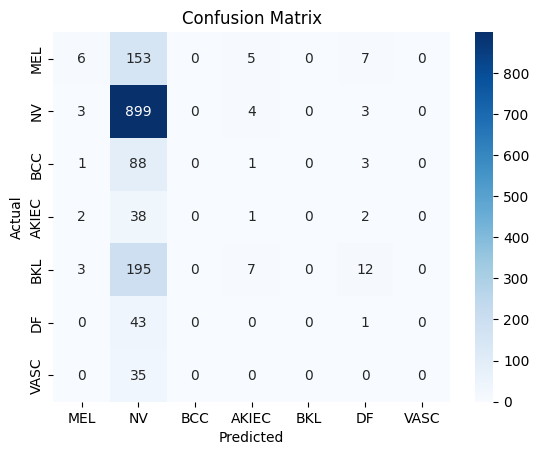


Sensitivity and Specificity per class:
Class: MEL
  Sensitivity: 0.0351
  Specificity: 0.9933
Class: NV
  Sensitivity: 0.9890
  Specificity: 0.0846
Class: BCC
  Sensitivity: 0.0000
  Specificity: 1.0000
Class: AKIEC
  Sensitivity: 0.0233
  Specificity: 0.9884
Class: BKL
  Sensitivity: 0.0000
  Specificity: 1.0000
Class: DF
  Sensitivity: 0.0227
  Specificity: 0.9816
Class: VASC
  Sensitivity: 0.0000
  Specificity: 1.0000

AUC (macro): 0.6725
AUC (micro): 0.7693
AUC (weighted): 0.7345
Balanced Accuracy (BACC): 0.1529


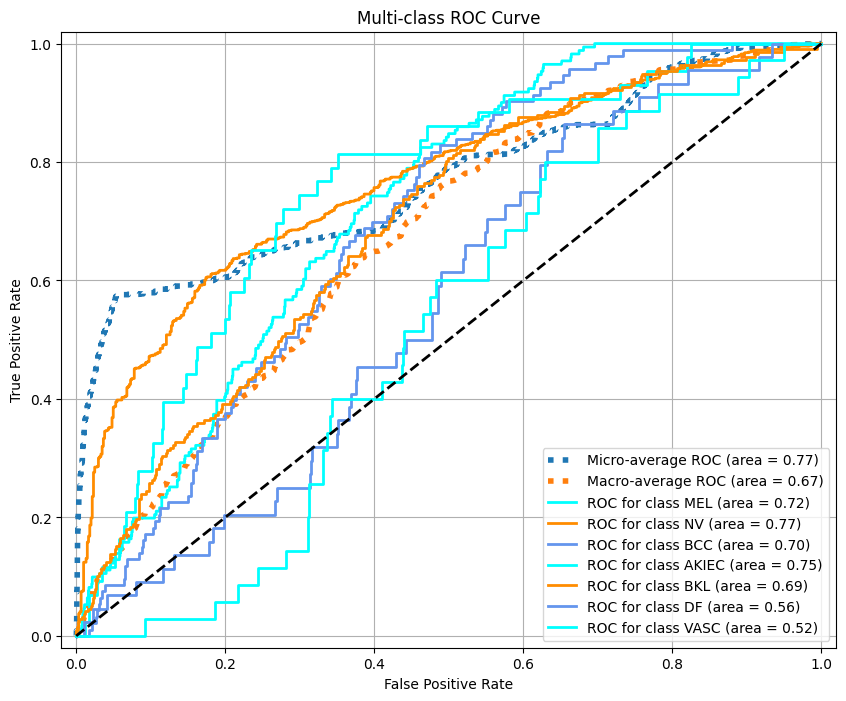

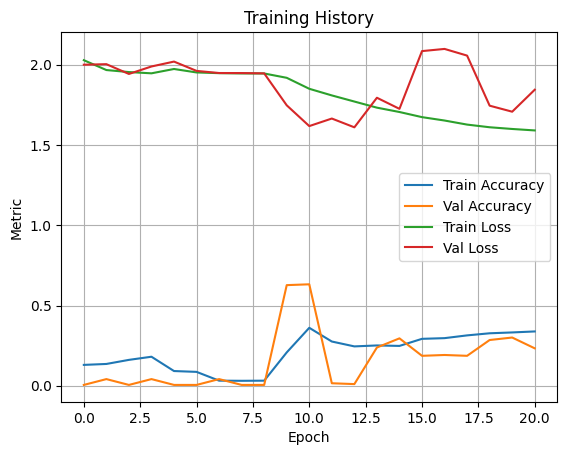

In [ ]:
#run the pipeline
main()